## Import Libaries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
import shap
import warnings
import matplotlib.pyplot as plt

c:\Users\Lenovo\Documents\KAIM\Week3\Insurance-Analytics\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

In [3]:
df = pd.read_csv('../data/processed/MachineLearning_task3.csv')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4728\1685332766.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/MachineLearning_task3.csv')


In [7]:
# Suppress warnings for cleaner notebook output
warnings.filterwarnings('ignore')

# --- Assuming 'df' is the cleaned DataFrame from Task 3 ---

## ----------------------------------------------------------------------
## 1. Data Preparation and Feature Engineering
## ----------------------------------------------------------------------

# 1.1 Feature Engineering: Vehicle Age
# Chaning 'TransactionMonth' and 'VehicleIntroDate' to datetime objects
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'])

df['VehicleAge_Years'] = (df['TransactionMonth'] - df['VehicleIntroDate']).dt.days / 365.25

# 1.2 Define Target Variables and Features
# Numerical features for scaling/direct use
NUMERICAL_FEATURES = ['TotalPremium', 'SumInsured', 'VehicleAge_Years'] 
# Categorical features for One-Hot Encoding (OHE)
CATEGORICAL_FEATURES = ['Province', 'CoverGroup', 'VehicleType', 'TermFrequency']

# Create Claim Flag and Log(Severity) Target
df['ClaimFlag'] = np.where(df['TotalClaims'] > 0, 1, 0)
df['LogTotalClaims'] = np.log1p(df['TotalClaims']) # Log transformation for severity

# Define the Column Transformer for preprocessing (Scikit-learn utility)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
    ],
    remainder='drop'
)

In [8]:
## ----------------------------------------------------------------------
## 2. Part 1: Claim Frequency Model (Classification)
## ----------------------------------------------------------------------

print("--- 2. Building Claim Frequency Models (Classification) ---")

# 2.1 Prepare Data for Frequency Model (Full Dataset)
X_freq = df[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
y_freq = df['ClaimFlag']

X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(
    X_freq, y_freq, test_size=0.2, random_state=42, stratify=y_freq 
)

# 2.2 Model Pipelines and Training

freq_models = {
    'Logistic Regression (Baseline)': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost Classifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
}

freq_results = {}
best_freq_model = None
best_auc = 0

for name, model in freq_models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train_freq, y_train_freq)
    
    y_pred_proba = pipeline.predict_proba(X_test_freq)[:, 1]
    auc = roc_auc_score(y_test_freq, y_pred_proba)
    
    freq_results[name] = {'AUC-ROC': auc}
    
    if auc > best_auc:
        best_auc = auc
        best_freq_model = pipeline

print("\nFrequency Model Evaluation (AUC-ROC):")
print(pd.DataFrame(freq_results).T.sort_values(by='AUC-ROC', ascending=False).to_markdown())

--- 2. Building Claim Frequency Models (Classification) ---

Frequency Model Evaluation (AUC-ROC):
|                                |   AUC-ROC |
|:-------------------------------|----------:|
| XGBoost Classifier             |  0.923194 |
| Random Forest Classifier       |  0.91436  |
| Logistic Regression (Baseline) |  0.63621  |


In [9]:
## ----------------------------------------------------------------------
## 3. Part 2: Claim Severity Model (Regression)
## ----------------------------------------------------------------------

print("\n--- 3. Building Claim Severity Models (Regression) ---")

# 3.1 Prepare Data for Severity Model (Claims > 0 Only)
df_severity = df[df['ClaimFlag'] == 1].copy()
X_sev = df_severity[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
y_sev = df_severity['LogTotalClaims'] # Use log-transformed target

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_sev, y_sev, test_size=0.2, random_state=42
)

# 3.2 Model Pipelines and Training

sev_models = {
    'Linear Regression (Baseline)': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost Regressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
}

sev_results = {}
best_sev_model = None
lowest_rmse = float('inf')

for name, model in sev_models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train_sev, y_train_sev)
    
    y_pred_sev = pipeline.predict(X_test_sev)
    
    # Calculate RMSE and R2 on the log-transformed data
    rmse = np.sqrt(mean_squared_error(y_test_sev, y_pred_sev))
    r2 = r2_score(y_test_sev, y_pred_sev)
    
    sev_results[name] = {'RMSE (Log)': rmse, 'R2 (Log)': r2}
    
    if rmse < lowest_rmse:
        lowest_rmse = rmse
        best_sev_model = pipeline

print("\nSeverity Model Evaluation (Log-Transformed):")
print(pd.DataFrame(sev_results).T.sort_values(by='RMSE (Log)').to_markdown())

# Print RMSE on back-transformed data for business context (Inverse of log1p is np.expm1)
y_pred_orig = np.expm1(best_sev_model.predict(X_test_sev))
y_test_orig = np.expm1(y_test_sev)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
print(f"\nBest Severity Model (Back-Transformed): RMSE = ${rmse_orig:,.2f}")


--- 3. Building Claim Severity Models (Regression) ---

Severity Model Evaluation (Log-Transformed):
|                              |   RMSE (Log) |   R2 (Log) |
|:-----------------------------|-------------:|-----------:|
| Random Forest Regressor      |     0.956807 |   0.662918 |
| XGBoost Regressor            |     1.02371  |   0.614127 |
| Linear Regression (Baseline) |     1.09696  |   0.55693  |

Best Severity Model (Back-Transformed): RMSE = $33,713.62



--- 4. Model Interpretability (SHAP) ---

SHAP Analysis Complete. Generating Summary Plot.


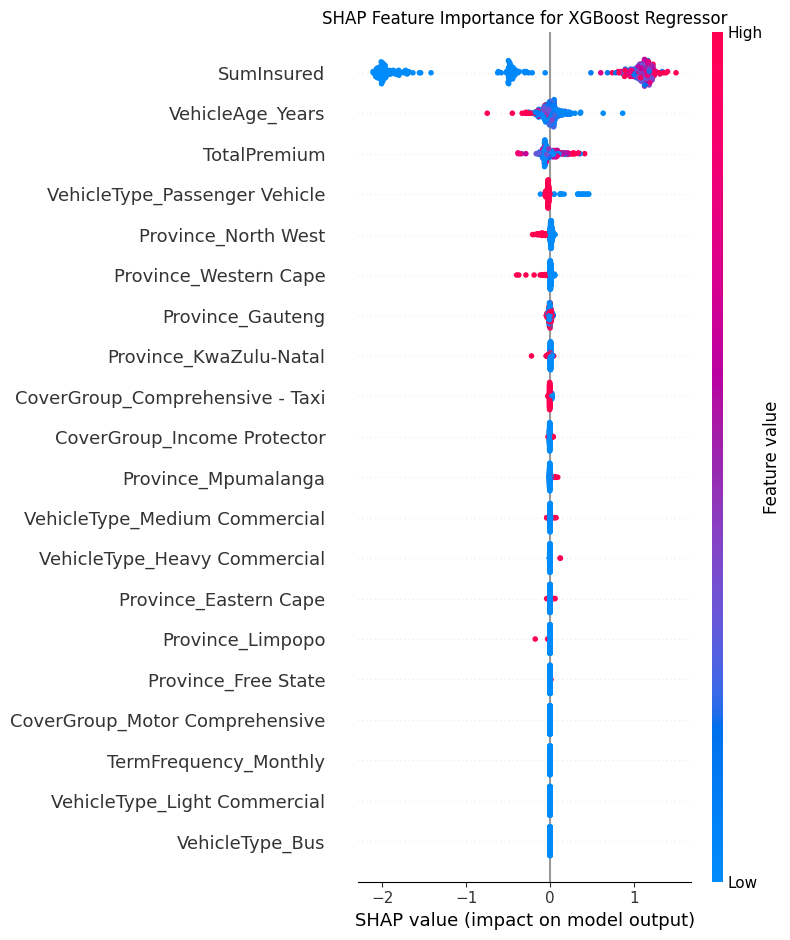

In [13]:
## ----------------------------------------------------------------------
## 4. Model Interpretability (SHAP Analysis)
## ----------------------------------------------------------------------

print("\n--- 4. Model Interpretability (SHAP) ---")

# Use the best performing XGBoost Regressor (or Classifier) for detailed analysis
best_model_name = 'XGBoost Regressor' # Update this based on your results
best_model_pipeline = best_sev_model

# 4.1 Extract the fitted XGBoost model and the processed data
# Select a small sample for faster SHAP calculation
X_test_sample = X_test_sev.sample(frac=0.5, random_state=42)
X_test_processed = best_model_pipeline.named_steps['preprocessor'].transform(X_test_sample)
model_to_explain = best_model_pipeline.named_steps['regressor'] # The final model itself

# 4.2 Get Feature Names after One-Hot Encoding
feature_names = (
    list(NUMERICAL_FEATURES) + 
    list(best_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(CATEGORICAL_FEATURES))
)

# 4.3 Run SHAP Explainer
explainer = shap.Explainer(model_to_explain, X_test_processed)
# SHAP calculation can be slow. Run this cell and wait.
shap_values = explainer(X_test_processed)

print("\nSHAP Analysis Complete. Generating Summary Plot.")

# Generate SHAP Summary Plot
plt.figure(figsize=(10, 6))
# This plot will clearly show the magnitude and direction of feature influence
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, show=False)
plt.title(f'SHAP Feature Importance for {best_model_name}')
plt.tight_layout()
plt.show() 

# The SHAP summary plot is essential for Task 4 reporting, providing actionable insights.

# 4.4 Business Interpretation
# Analyze the top 5 features from the plot and discuss business impact in the final report.
# Example: "SHAP analysis for the Claim Severity Model reveals that VehicleAge_Years has a negative correlation with claims for newer vehicles, but a strong positive correlation for vehicles over 10 years old, confirming the need for age-based premium adjustments."